In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

model_number = 'model8'

In [2]:
# Create datasets
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()

batch_size = 128
train_dataset_augmented, epoch_length = kaggle.augment_dataset(train_dataset, batch_size)

### VGG-style with residual blocks

In [12]:
class VGGRes(kt.HyperModel):
    def residual_module(self, input, filters, stride=1, bottleneck=0, l2_reg=0, batch_norm=0.99):
        # Applies bottleneck if necessary, to reduce dimensions
        if bottleneck > 0:
            conv_0 = layers.Conv2D(
                bottleneck, kernel_size=(1,1),
                padding='same', activation='relu',
                kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
                kernel_initializer='he_normal')(input)
        else:
            bottleneck = filters
            conv_0 = input

        # Applies relu convolution, then linear convolution before shortcut
        conv_1 = layers.Conv2D(
            bottleneck, kernel_size=(3,3), strides=(stride, stride),
            padding='same', activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_normal')(conv_0)
        conv_2 = layers.Conv2D(
            filters, kernel_size=(3,3), 
            padding='same', activation='linear',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_normal')(conv_1)
        
        # Ensures shortcut is correct depth by adding a 1x1 convolution
        if input.shape[-1] != filters:
            shortcut = layers.Conv2D(
                filters, kernel_size=(1,1), strides=(stride,stride),
                padding='same', activation='relu',
                kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
                kernel_initializer='he_normal')(input)
        else:
            shortcut = input

        # Adds shortcut
        addition = layers.add([conv_2, shortcut])

        # Batch Norm is performed in the original paper
        addition = layers.BatchNormalization(momentum=batch_norm)(addition)

        activation = layers.Activation('relu')(addition)
        return activation

    def conv_layer(self, input, filters, stride=1, kernel=3, l2_reg=0, padding='same'):
        return layers.Conv2D(
            filters, kernel_size=(kernel,kernel), strides=(stride,stride), 
            padding=padding, activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_uniform')(input)

    def build(self, hyperparameters):
        # Tunable hyperparameters
        if hyperparameters is not None: 
            dense_l2_reg = hyperparameters.Float('dense_l2_reg', 0.00001, 0.001, sampling='log')
            dense_dropout = hyperparameters.Float('dense_dropout', 0.3, 0.5, step=0.1)
        else:
            dense_l2_reg = 0.0001
            dense_dropout = 0.6

        # Fixed hyperparameters
        learning_rate = 0.0005
        conv_12_reg = 0.00001

        input_layer = layers.Input(shape=(96, 96, 1))

        output = self.conv_layer(input_layer, 32, stride=2, l2_reg=conv_12_reg)
        output = self.conv_layer(output, 32, l2_reg=conv_12_reg)
        output = layers.BatchNormalization()(output)
        
        output = self.conv_layer(output, 64, stride=2, l2_reg=conv_12_reg)
        output = self.conv_layer(output, 64, l2_reg=conv_12_reg)
        output = layers.BatchNormalization()(output)

        output = self.residual_module(output, 128, stride=2, l2_reg=conv_12_reg)

        output = self.residual_module(output, 256, stride=2, l2_reg=conv_12_reg)

        output = self.residual_module(
            output, 512, stride=2, bottleneck=256, l2_reg=conv_12_reg)

        # Final output
        output = layers.Flatten()(output)
        output = layers.Dropout(dense_dropout / 2)(output)
        output = layers.Dense(
            128, activation='relu', kernel_initializer='he_uniform',
            kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)
        output = layers.Dropout(dense_dropout)(output) 
        output = layers.Dense(
            11, kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(learning_rate),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

# VGGRes().build(None).summary()

In [ ]:
# Hyperparameter tuning
# Took 5hrs for 8 trials with 250 epochs and LR decrease

reload_tuner = True
tuner_filepath = 'hypertuner_2021-11-28_fewer_blocks'

tuner_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20 - 10, min_lr=0.00001)
]

tuner = kt.RandomSearch(VGGRes(),
    objective='val_accuracy',
    max_trials=3,
    seed=10,
    directory=f'models/{model_number}',
    project_name=tuner_filepath,
    overwrite=(not reload_tuner))

# tuner.search_space_summary()

if reload_tuner:
    tuner.reload()
else:
    tuner.search(
        train_dataset_augmented, 
        validation_data=valid_dataset.batch(128).cache(),
        epochs=250, steps_per_epoch=epoch_length,
        callbacks=tuner_callbacks, verbose=1)

tuner.results_summary()

# model = tuner.get_best_models(1)[0]

In [13]:
# Fit model 
print('Building new model')
model, history = kaggle.train_model(
    VGGRes().build(None), train_dataset_augmented, valid_dataset, 
    epochs=200, valid_patience=30, epoch_length=epoch_length)

Building new model
Epoch 1/200
75/75 [==============================] - 28s 314ms/step - loss: 2.5028 - accuracy: 0.1606 - val_loss: 2.4237 - val_accuracy: 0.1522 - lr: 5.0000e-04
Epoch 2/200
75/75 [==============================] - 18s 237ms/step - loss: 2.4283 - accuracy: 0.1928 - val_loss: 2.4079 - val_accuracy: 0.1585 - lr: 5.0000e-04
Epoch 3/200
75/75 [==============================] - 23s 301ms/step - loss: 2.4041 - accuracy: 0.2043 - val_loss: 2.4091 - val_accuracy: 0.1594 - lr: 5.0000e-04
Epoch 4/200
75/75 [==============================] - 22s 299ms/step - loss: 2.3885 - accuracy: 0.2112 - val_loss: 2.3530 - val_accuracy: 0.1791 - lr: 5.0000e-04
Epoch 5/200
75/75 [==============================] - 22s 299ms/step - loss: 2.3864 - accuracy: 0.2116 - val_loss: 2.3376 - val_accuracy: 0.2098 - lr: 5.0000e-04
Epoch 6/200
75/75 [==============================] - 22s 298ms/step - loss: 2.3687 - accuracy: 0.2185 - val_loss: 2.3196 - val_accuracy: 0.2140 - lr: 5.0000e-04
Epoch 7/200
75/

INFO:tensorflow:Assets written to: models/model8/VGGRes_2\assets


C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


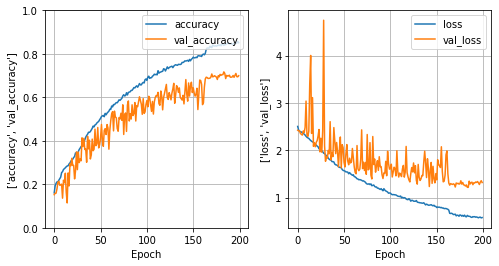

In [14]:
# Plot model statistics during training
kaggle.plot_model_history(history, [['accuracy', 'val_accuracy'], ['loss', 'val_loss']])

# Save model
model_name = 'VGGRes_2'
model.save(f'models/{model_number}/{model_name}')


In [5]:
# Tune model
print('Fine-tuning model')
fine_model, history = kaggle.fine_tune_model_filepath(
    f'models/{model_number}/VGGRes_2',
    train_dataset.batch(128).cache(), valid_dataset, 
    epochs=10, learning_rate=0.00001)

Fine-tuning model
Epoch 1/10
75/75 [==============================] - 30s 350ms/step - loss: 0.3452 - accuracy: 0.9294 - val_loss: 0.9100 - val_accuracy: 0.7746
Epoch 2/10
75/75 [==============================] - 24s 324ms/step - loss: 0.3187 - accuracy: 0.9374 - val_loss: 0.8514 - val_accuracy: 0.7910
Epoch 3/10
75/75 [==============================] - 21s 285ms/step - loss: 0.3015 - accuracy: 0.9422 - val_loss: 0.8404 - val_accuracy: 0.7931
Epoch 4/10
75/75 [==============================] - 22s 296ms/step - loss: 0.2888 - accuracy: 0.9461 - val_loss: 0.8432 - val_accuracy: 0.7948
Epoch 5/10
75/75 [==============================] - 22s 298ms/step - loss: 0.2723 - accuracy: 0.9489 - val_loss: 0.8512 - val_accuracy: 0.7948
Epoch 6/10
75/75 [==============================] - 23s 310ms/step - loss: 0.2648 - accuracy: 0.9517 - val_loss: 0.8592 - val_accuracy: 0.7956
Epoch 7/10
75/75 [==============================] - 22s 298ms/step - loss: 0.2512 - accuracy: 0.9588 - val_loss: 0.8708 - va

In [6]:
# Save fine-tuned model
fine_model.save(f'models/{model_number}/VGGRes_3_79')

INFO:tensorflow:Assets written to: models/model8/VGGRes_3_79\assets


C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Evaluate model

In [ ]:
model_to_evaluate = 'VGGRes_1_76'
loaded_model = keras.models.load_model(f'models/{model_number}/{model_to_evaluate}')

test_pred_raw = loaded_model.predict(valid_dataset.batch(128))
test_pred = np.argmax(test_pred_raw, axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)